<a href="https://colab.research.google.com/github/Soumo275/ecg_diagnosis_deep_learning/blob/main/ecg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d jayaprakashpondy/ecgimages


Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/ecgimages
License(s): unknown
 99% 283M/286M [00:01<00:00, 151MB/s]
100% 286M/286M [00:01<00:00, 167MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/ecgimages.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


In [4]:
IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
training_data='train'
training_image_data  = image_generator.flow_from_directory(training_data,target_size=IMAGE_SHAPE)

Found 928 images belonging to 4 classes.


In [5]:
training_image_data[1][1].shape


(32, 4)

In [6]:
validation_data='test'
validation_image_data  = image_generator.flow_from_directory(validation_data,target_size=IMAGE_SHAPE)

Found 448 images belonging to 4 classes.


In [7]:
class_names = sorted(training_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Ecg Images Of Myocardial Infarction Patients (240X12=2880)',
       'Ecg Images Of Patient That Have History Of Mi (172X12=2064)',
       'Ecg Images Of Patient That Have Abnormal Heartbeat (233X12=2796)',
       'Normal Person Ecg Images (284X12=3408)'], dtype='<U64')

In [8]:
ResNet50 = tf.keras.applications.ResNet50
model_arch = ResNet50(weights='imagenet', include_top=True)

model_arch.summary()

102967424/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [9]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [10]:
feature_extractor = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [11]:
model = tf.keras.Sequential([feature_extractor])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
Total params: 23564800 (89.89 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [12]:
for image_batch, label_batch in training_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 4)


In [13]:
# Change the number of units in the final dense layer to match the number of classes in your labels.
model_ecg = tf.keras.Sequential([feature_extractor ])
model_ecg.add(tf.keras.layers.Dense(4)) # Assuming you have 4 classes
model_ecg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23572996 (89.92 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [14]:
model_ecg.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [15]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [17]:
history = model_ecg.fit(training_image_data, epochs = 16,
                          validation_data=validation_image_data,
                          callbacks=[batch_stats_callback],
                          )

Epoch 1/16
29/29 [==============================] - 30s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.5518 - val_acc: 0.8192
Epoch 2/16
29/29 [==============================] - 30s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.5335 - val_acc: 0.8326
Epoch 3/16
29/29 [==============================] - 30s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.5211 - val_acc: 0.8504
Epoch 4/16
29/29 [==============================] - 29s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.5388 - val_acc: 0.8170
Epoch 5/16
29/29 [==============================] - 31s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.4941 - val_acc: 0.8527
Epoch 6/16
29/29 [==============================] - 30s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.4913 - val_acc: 0.8438
Epoch 7/16
29/29 [==============================] - 30s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.4981 - val_acc: 0.8482
Epoch 8/16
29/29 [================

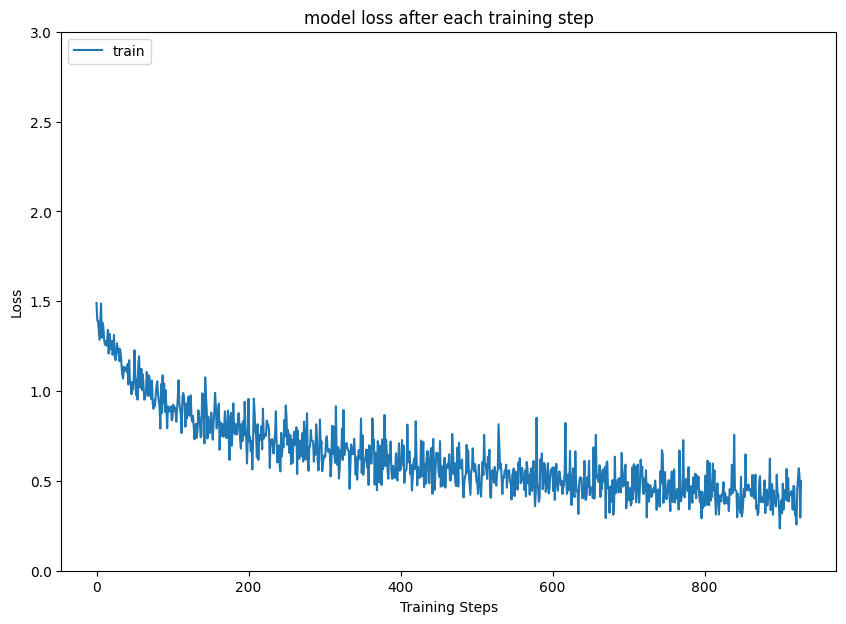

In [18]:
plt.figure(figsize=(10,7))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,3])
plt.plot(batch_stats_callback.batch_losses)
plt.title('model loss after each training step')
plt.legend(['train'], loc='upper left')

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


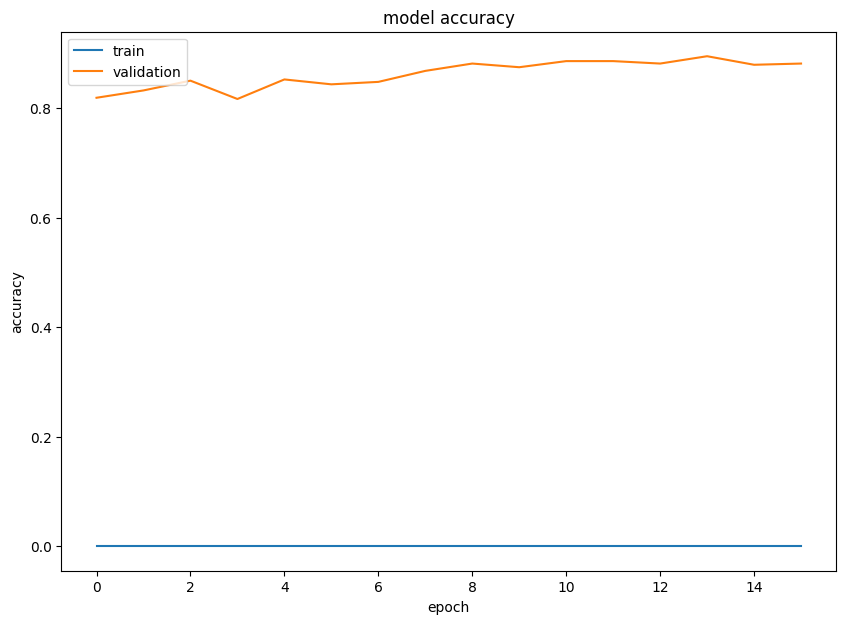

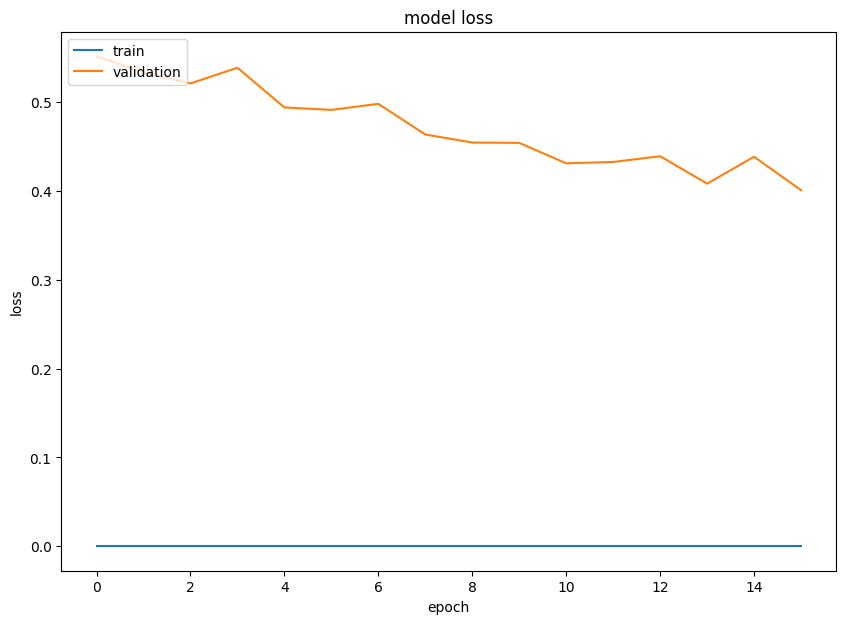

In [19]:
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(10,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
arr = model_ecg.predict(image_batch)
predicted_id = np.argmax(arr, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)
true_label_batch = class_names[label_id]

1/1 [==============================] - 1s 667ms/step


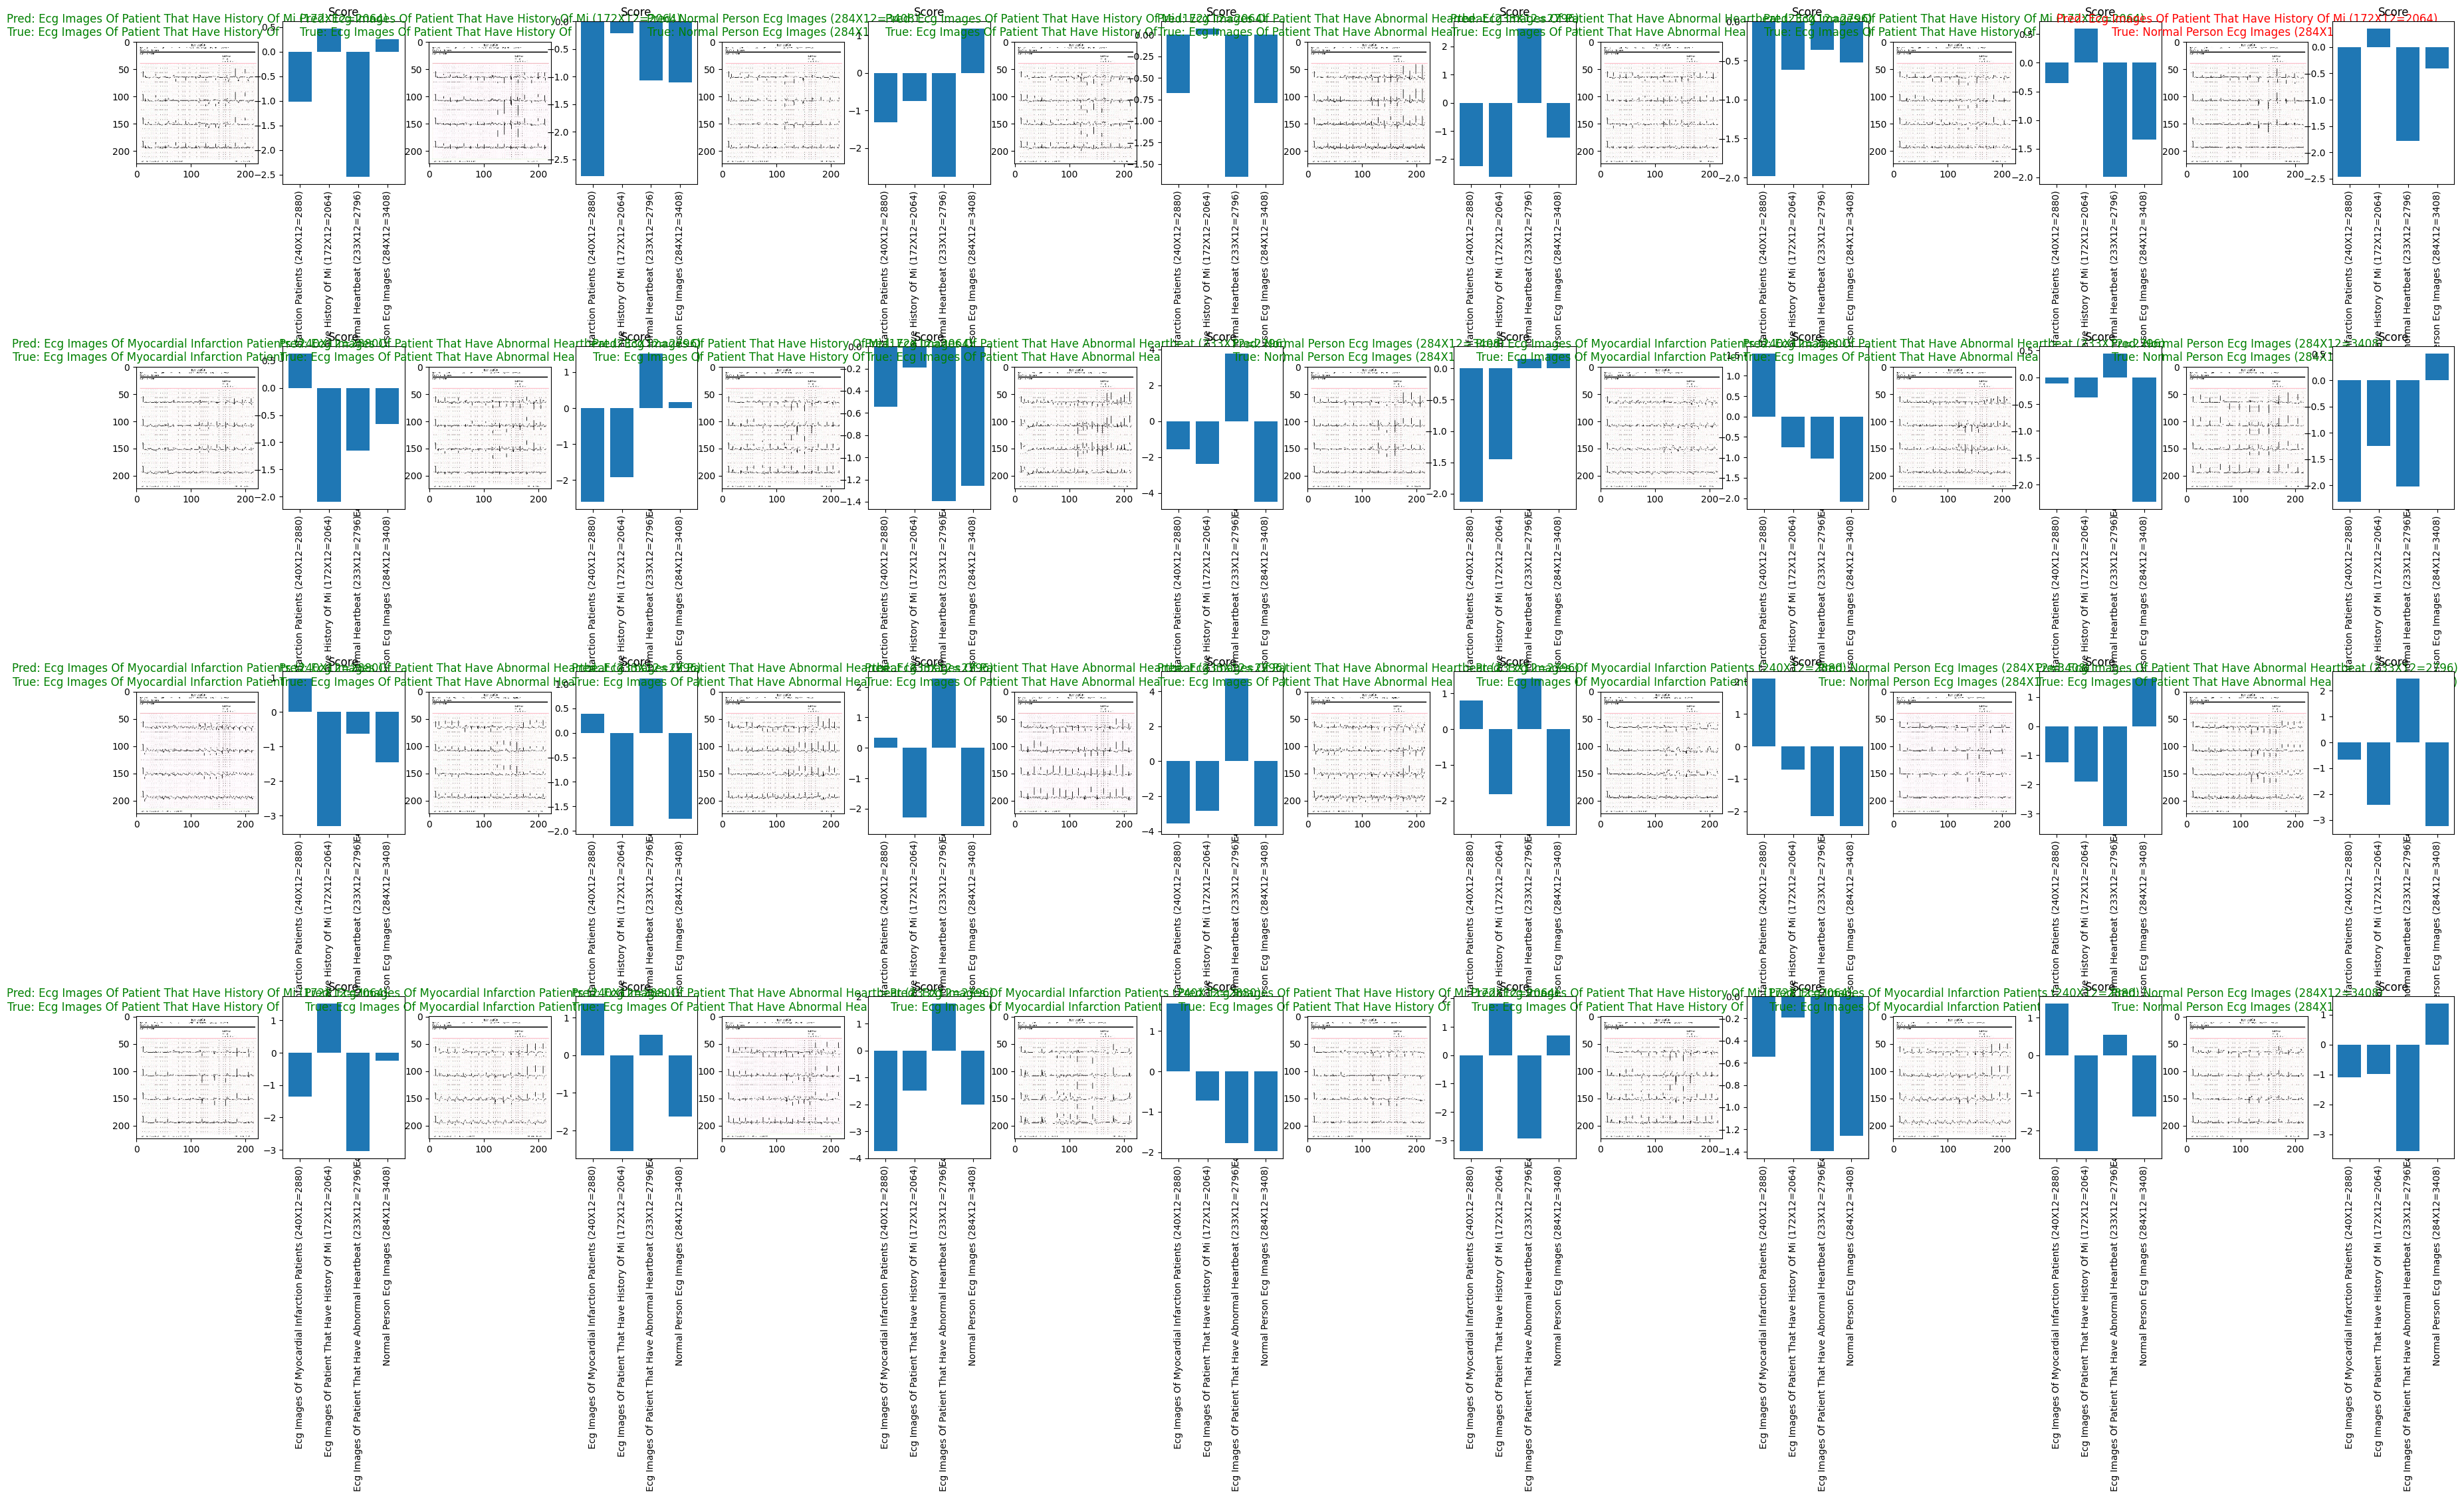

In [23]:
img_counter=0
prob_counter=0

plt.figure(figsize=(45,200))
plt.subplots_adjust(hspace=1)
for n in range(64):

  plt.subplot(32,16,n+1)
  if(n%2==0 and img_counter < len(image_batch)): # Check if img_counter is within bounds
      plt.imshow(image_batch[img_counter])
      color = "green" if predicted_id[img_counter] == label_id[img_counter] else "red"
      plt.title("Pred: "+predicted_label_batch[img_counter].title()+"\nTrue: "+true_label_batch[img_counter], color=color)
      img_counter=img_counter+1

  if(n%2==1 and prob_counter < len(arr)): # Check if prob_counter is within bounds
      plt.title("Score", color="Black")

      data=[arr[prob_counter][0],arr[prob_counter][1],arr[prob_counter][2],
            arr[prob_counter][3]
            ]

      plt.bar(class_names,data)
      plt.xticks(rotation='vertical')

      prob_counter=prob_counter+1

In [25]:
# save the model and use it to predict an image

import numpy as np
model_ecg.save('ecg_model.h5')



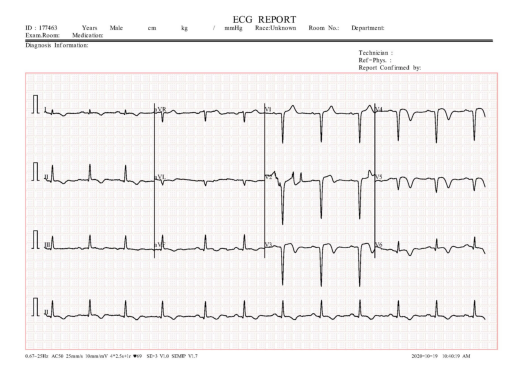

In [27]:
# prompt: show the input image version

import matplotlib.pyplot as plt

# Load the image
image = plt.imread('ecg.jpg')

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


In [26]:
import tensorflow as tf
import tensorflow_hub as hub

# Define the custom object scope
custom_objects = {"KerasLayer": hub.KerasLayer}

# Load the saved model with custom objects
with tf.keras.utils.custom_object_scope(custom_objects):
    loaded_model = tf.keras.models.load_model('ecg_model.h5')

# Predict an image
image_path = 'ecg.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = image / 255.0

prediction = loaded_model.predict(image)

predicted_class_id = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_id]

print("Predicted class:", predicted_class_name)

1/1 [==============================] - 2s 2s/step
Predicted class: Ecg Images Of Patient That Have History Of Mi (172X12=2064)
